In [1]:
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import os
import skimage.data
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform 
from skimage.color import rgb2gray


I am shamelessly cribbing from code by Doug Brinkerhoff for this first example, writen for CSCI 547.
and https://www.tensorflow.org/versions/r1.3/get_started/estimator
For the second. 

In [3]:
# Tensorflow has the mnist data builtin
data_dir = '/tmp/tensorflow/mnist/input_data'

# Import data
mnist = input_data.read_data_sets(data_dir,one_hot=True)

n = 784  # Number of input features
N = 10   # Number of classes
L = 300  # Number of hidden nodes

# X is the vector of inputs (though it's just a placeholder until a tensorflow session is started)
X = tf.placeholder("float", [None, n])

# y is the vector of targets
y = tf.placeholder("float", [None, N])

# Create the model
# layer 1 weights and biases
W_0 = tf.Variable(tf.random_normal([n,L],stddev=0.01))
b_0 = tf.Variable(tf.random_normal([L],stddev=0.01))
# layer 2 weights and biases 
W_1 = tf.Variable(tf.random_normal([L,L],stddev=0.01))
b_1 = tf.Variable(tf.random_normal([L],stddev=0.01))
# layer 3 weights and biases 
W_2 = tf.Variable(tf.random_normal([L,N],stddev=0.01))
b_2 = tf.Variable(tf.random_normal([N],stddev=0.01))

# Create neural network
def multilayer_perceptron(x):
    Z1 = tf.add(tf.matmul(x,W_0),b_0)
    A1 = tf.sigmoid(Z1)
    Z2 =tf.add(tf.matmul(A1,W_1),b_1)
    A2 = tf.sigmoid(Z2)
    out_layer = tf.add(tf.matmul(A2,W_2),b_2)
    return out_layer

# define prediction object
y_pred = multilayer_perceptron(X)


# Define loss function (combined softmax and cross-entropy output) 
loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))

#Regularization, if you please.
beta = .001
regularizers = tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2)
loss_op = tf.reduce_sum(loss_op + beta * regularizers)

# Specify learning rate
learning_rate = 0.001

# Define optimization step
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# The optimization procedure (minimizing the softmax cross_entropy)
train_op = optimizer.minimize(loss_op)

# Initialize all the variables
# (tensorflow doesn't compute variable values unless run by as session)
sess = tf.InteractiveSession()
init  = tf.global_variables_initializer().run()

# Train
N_iterations = 10000
sample_size = 10

for i in range(N_iterations):

    # Pull a sample from the training set
    batch_xs, batch_ys = mnist.train.next_batch(sample_size)

    # Run tensor flow objects: train_op updates the weights, loss_op compute the cost function
    _,c = sess.run([train_op,loss_op], feed_dict={X: batch_xs, y: batch_ys})

    # Print statistics every 1000 steps
    if i%1000==0:
        # Test trained model
        pred = tf.nn.softmax(y_pred)
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({X: mnist.test.images, y: mnist.test.labels}),c)

# You can acquire the values of your layer weights with
w = sess.run(W_2)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Accuracy: 0.1135 22.8589
Accuracy: 0.8883 1.80559
Accuracy: 0.9194 1.95172
Accuracy: 0.9351 1.98756
Accuracy: 0.9404 1.07356
Accuracy: 0.9447 2.17545
Accuracy: 0.9497 4.48461
Accuracy: 0.9569 3.29789
Accuracy: 0.9443 2.59971
Accuracy: 0.9607 1.04619


Obviously this glosses over a lot of the process of prepping and running a dataset through, so let's step back and go through the Wisconsin breast cancer dataset. I want to illustrate an even faster approach, though, using the .estimator set of tools. 

In [4]:
from collections import namedtuple
import numpy as np

def breastCancerData(file = 'breast-cancer-wisconsin.txt'):    
    dataSet = namedtuple('trainingSet','X Y labels')
    f = open(file,'r')
    data = f.read()
    f.close()
    records = data.split('\n')

    n = len(records)-1
    p = len(records[0].split(','))-2
    s = 2 # number of classes
    Y = np.matrix(np.zeros(shape = (n, s)))
    X = np.matrix(np.ones(shape = (n, p)))
    labels = [0]*n
    for i, line in enumerate(records):
        record = line.split(',')

        try:
            labels[i] = int(record[p+1]=='4')
            Y[i,labels[i]] = 1
            ''' scale variables by dividing by 10 '''
            X[i,:] =  [int(x)/10 for x  in record[1:p+1]]

        except(ValueError,IndexError):
            pass
    labels = [np.argmax(Y[i,:]) for i in range(n)]
    data = dataSet(X, Y,  labels) 
    return data

#Extract X and Y matrices so:
D = breastCancerData()
BCX,BCX_test,BCY,BCY_test = train_test_split(D.X,np.array(D.labels),test_size=0.33,random_state=551)
BCX,BCX_test,BCY,BCY_test = np.array(BCX),np.array(BCX_test),np.array(BCY),np.array(BCY_test)


In [5]:
assert BCX.shape[0] == BCY.shape[0]
#Making sure our data lines up

In [10]:
#We don't actually need to do much data prep outside of what we've got, as numpy is a readily accepted format
#for recent TF versions. We simply setup some parameters, specify our classifier and roll!
feature_columns = [tf.feature_column.numeric_column("x", shape=[9])]
# The nine here specifies our features (9 in this data)
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=[1, 1, 1],
                                        n_classes=2)
#Some arbitrary setup
"""The tf.estimator API uses input functions, which create the 
TensorFlow operations that generate data for the model. 
We can use tf.estimator.inputs.numpy_input_fn to produce the input pipeline:"""

#So we just point this simple as hell DNN at our data 
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": BCX},
    y=np.array(BCY),
    num_epochs=None,
    shuffle=True)
#annnd
classifier.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/28/txbthpc56gl12cg_7_wchkzm0000gn/T/tmpfhxegv0n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2dc56518>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/28/txbthpc56gl12cg_7_wchkzm0000gn/T/tmpfhxegv0n/model.ckpt.
INFO:tensorflow:loss = 88.789, step = 1
INFO:tensorflow:global_step/sec: 623.193
INFO:tensorflow:loss = 85.7623, step = 101 (0.161 sec)
INFO:tensorflow:global_step/sec: 773.078
INFO:tensorflow:loss = 87.6044, step = 

In [12]:
#Okay, so let's see how accurate it is on our test data
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": BCX_test},
    y=np.array(BCY_test),
    num_epochs=1,
    shuffle=False)
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]

print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

classifier.predict(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2018-05-07-21:41:43
INFO:tensorflow:Restoring parameters from /var/folders/28/txbthpc56gl12cg_7_wchkzm0000gn/T/tmpfhxegv0n/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-05-07-21:41:44
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.683983, accuracy_baseline = 0.683983, auc = 0.5, auc_precision_recall = 0.658009, average_loss = 0.628076, global_step = 2000, label/mean = 0.316017, loss = 72.5428, prediction/mean = 0.35981

Test Accuracy: 0.683983



<generator object Estimator.predict at 0x1c2f8f61a8>

Well, that was easy! What was the point of this class if we only need 30 lines to make a neural net?!

Obviously we lose a lot of granular control over this model, for example using the premade estimator framework we can't impliment any form of regularization or gradient descent methodology, we're at the whim of the presets. 
There are a lot of shades between these two examples including custom estimator layers that allow the introduction of regularization and more. See https://www.tensorflow.org/get_started/custom_estimators.

For a final example, something a little more fun that tensorflow is geared toward: image recognition. I'm following a 'recipe' from https://www.datacamp.com/community/tutorials/tensorflow-tutorial , because I am not really inately versed in TF workings. This example looks as traffic signs.

In [17]:
#We start with some pre-writen functions to, again, collect our data. 
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

images, labels = load_data('Training')
test_images, test_labels = load_data("Testing")

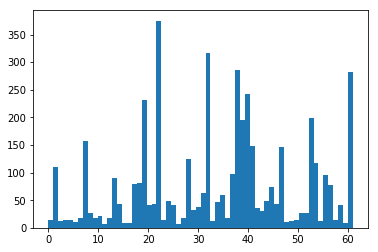

In [18]:
plt.hist(labels, 62)

plt.show()


Here we can see the distributions of the labels devoted to our special 62 traffic signs. But what's that spike? Looks like label 33ish, let's look at some of those.

In [19]:
labels.count(33)

12

In [20]:
#Hmm, too small.
labels.count(32)

316

In [21]:
#there it is!
labels.index(32)

1834

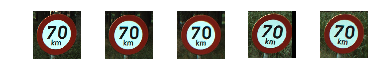

In [22]:
traffic_signs = [sign for sign in range(1834,1839)]

# Fill out the subplots with the random images that you defined 
for i in range(len(traffic_signs)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)

plt.show()

Oh. Yea, of course, the ole' 70km sign! Anyways, this chunk of code is actually meant to operate as follows:

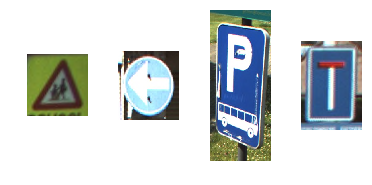

In [23]:
traffic_signs = [300, 2250, 3650, 4000]

# Fill out the subplots with the random images that you defined 
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)

plt.show()

There is a great deal more exploration of the data here in the tutorial, including understanding that histogram distribution and the sizes of the sign images. I'd encourage reading the full tutorial for more in depth analysis of how to approach this set. I'm just here for the tesnorflow! 

That said, we'll need to address two issues: We need to scale all of our images to be the same size and we need to remove color from the images as it carries a lot of superfluous information. 


In [24]:
#And all we need to rescale is this!
images28 = [transform.resize(image, (28, 28)) for image in images]
test_images28 = [transform.resize(image, (28, 28)) for image in test_images]

/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


And so:


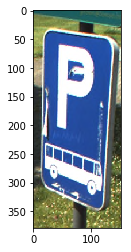

Becomes:


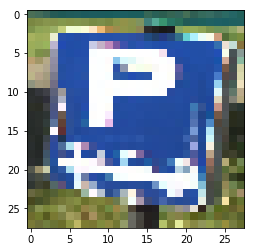

In [25]:
print("And so:")
plt.imshow(images[3650])
plt.show()
print("Becomes:")
plt.imshow(images28[3650])
plt.show()

In [26]:
#Now we greyscale, again using skimages powerful toolset.
# We'll need to make this conversion sooner or later, might as well do it now.
images28 = np.array(images28)
print("Here's our array shape prior to greyscaling: ",images28.shape)
images28 = rgb2gray(images28)
print("Here's our array shape after: ",images28.shape)
# Annnnd done. It's worth nothing that this process also essentially scales our data, which tf requires.
test_images28 = rgb2gray(np.array(test_images28))

Here's our array shape prior to greyscaling:  (4575, 28, 28, 3)
Here's our array shape after:  (4575, 28, 28)


In [27]:
print(images28[1][1][0:10]) #Printing some arbitrary pixels to make a point.
print("Notice that all of the values fall between 0 and 1")

[ 0.15332047  0.19638611  0.41005806  0.34110699  0.33556795  0.35972723
  0.33463268  0.32403808  0.33376531  0.35465769]
Notice that all of the values fall between 0 and 1


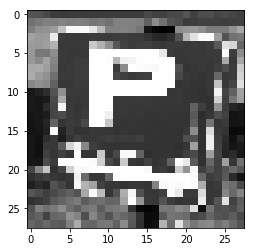

In [28]:
plt.imshow(images28[3650], cmap="gray")
plt.show()

In [38]:
# Much like in Doug's code, the proper 'construct' for tf is to 
#initialize a placeholder to fill with the data as it's read in
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Flatten the input data. This is just how tensorflow takes data, as row vectors feeding one observation at a time.
# That makes our 28*28 images into simply a series of 784 greyscale pixel values.
images_flat = tf.contrib.layers.flatten(x)

# Fully connected layer with logits of output size 62, using a reylu function.
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.tanh)

# Here we define the loss function we want to use; in this case because we have mutually exclusive class membership,
# we are looking for a softmax for a sparse matrix.
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, 
                                                                    logits = logits))
# Define an optimizer. I part with the tutorial here to use a Gradient Descent Optimizer instead of 
# ADAM (adaptive moment estimation), which is essentially a refined gradient descent. The point is you have options.
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# Convert logits to label indexes
correct_pred = tf.argmax(logits, 1)

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [39]:
tf.set_random_seed(88)
#The session structure is how to initalize a connection to tensorflow, here we define our session, run it, 
#then create a for-loop to run through out 201 epochs. 
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(10000):
    if i%1500 == 0:
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: images28, y: labels})
        if i % 10 == 0:
            print("Loss: ", loss)

EPOCH 0
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 1500
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 3000
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 4500
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 6000
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 7500
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)
EPOCH 9000
Loss:  Tensor("Mean_26:0", shape=(), dtype=float32)


Again, despite a longer road, pretty easy to get going! Now we just need to appraise this model using our test signs, which we transformed and greyscaled in tandem with the training set. 

In [40]:
#This format allowas us to catalogue tensor's output and compare it to the observed categories. 
predicted = sess.run([correct_pred], feed_dict={x: test_images28})[0]
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)


In [41]:
print("Accuracy = ", round((accuracy*100),2),"%")

Accuracy =  5.6 %


Well, that sucks! Indeed, this problem is one for tweaking, and, especially, implimenting some regularization on. Doing that requires cracking the code out another stage, as we saw in the first example, and applying regularization between the weights and forward propegation.


In [37]:
sess.close() #don't forget to close the session.